# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
#### Do not run this again
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 1.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

###  Let's define the Agent class now alongwith the Q Network that we will use.

In [13]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple,deque

Buffer_Size = int(1e5)  # replay buffer size
Batch_Size = 64         # minibatch size
gamma = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



class Agent():
    
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        # the state size and action size will be used to generate the Q Network
        self.state_size = state_size
        self.action_size = action_size
        ### random.seed(seed) generates sequence of random numbers by performing some operation on initial value.
        #If same initial value is used, it will generate the same sequence of random numbers
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = Replay_Buffer(action_size, Buffer_Size, Batch_Size, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
      
    def select_act(self, state, eps=0.):
        
        " selects action based on state and epsilon"
        
        # get the state array from env, convert to tensor
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device) 
        
        # unsqueeze(0) adds a singleton dimension at 0 positon
        # useful because the states are in batches     
        # to(device) moves the tensor to the device memory, cpu or cuda
        
        ## put network in eval mode
        self.qnetwork_local.eval()
        
        #get last_layer of the network to retrive index of the max reward
        with torch.no_grad(): # torch.no_grad() prevents calculating gradients in the following block, so no backward_pass.
            action_values = self.qnetwork_local(state)
        
        self.qnetwork_local.train()
        
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return np.random.randint(self.action_size)        # select an action
        #random.choice(np.arange(self.action_size)) 
    
    def learn(self,experiences,gamma):
        
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values (for next states) from target model
        Q_next_states = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        # detach returns a new tensor detachd from the current graph
        # final layer is (batch_size ,action_size)i.e. (64,4), max(1), will find max in the second dim(1)
        # the new tensor is (64,), we then add a singleton dimensin to it with unsqueeze
        # Q_targets_next is the max reward of the four actons for each of the 64 states
        
        Q_target = rewards + (gamma*Q_next_states*(1-dones))
        
        
        Q_expected = self.qnetwork_local(states).gather(1,actions)
        
        #gather rearranges values in the dimension (1 here) of the input tensor (64,4), 
        #as per the indices in the index tensor provided, actions here...actions carries the index of the next action taken
        # given the state in states. SO only one value will be provided..it coud be either of 0,1,2,3..based on def act and state
        #therefore output is 64,1.with reward corresponding to only that action chosen after the state.
        
        # the rewars generated by q_network local is used for comparison with Q_targets to calc.loss
        #then we update parametrs to min loss

        
        loss = F.mse_loss(Q_expected,Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        
        
    def step(self,state,action,reward,next_state,done):
        
        self.memory.add(state,action,reward,next_state,done)
        
        self.t_step = (self.t_step+1) % UPDATE_EVERY # self.t_step will increase by 1 after every step() call
                                                    # that means every time step
        if self.t_step == 0:
            if len(self.memory) > Batch_Size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma)
    
    def soft_update(self, local_model, target_model, TAU):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)


                
class Replay_Buffer:
    
    def __init__(self, action_size, Buffer_Size, Batch_Size,seed):
             
        self.action_size = action_size
        self.memory = deque(maxlen=Buffer_Size)  
        self.Batch_Size = Batch_Size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state,action,reward,next_state,done):
        
        e = self.experience(state,action,reward,next_state,done) 
        # add state,action... values to the named tuple self.experience
        
        return self.memory.append(e)
    
    def sample(self):
        
        experiences = random.sample(self.memory, k = self.Batch_Size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)    
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)  
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)        
        
        return (states,actions,rewards,next_states,dones)
    
    def __len__(self):
        return len(self.memory)
    

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
        
        


## Let's run the cell below and printout some information about the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
print(state.shape)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
(37,)
States have length: 37


In [8]:
agent = Agent(state_size = 37, action_size = 4, seed = 0)

In [9]:
def dqn_unity(num_episodes = 2000,  eps_start = 1, eps_decay=0.995, eps_end = 0.01):
    
    scores = [] # list of scores from each episode
    score_window = deque(maxlen = 100) # a deque of 100 episode scores to average
    eps = eps_start
    
    for i_episode in range(1,num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        
        score = 0
        while True:
       
                   
            action = agent.select_act(state,eps)           # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state,action,reward,next_state,done)
            score += reward
            state = next_state
            
            if done:
                break
                
        scores.append(score)
        score_window.append(score)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(score_window)))
        if np.mean(score_window)>=13:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(score_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'Banana_saved_model.pth')
            break
            
    return scores


            
            
            
            
            


## Let's train our agent to solve the environment

Episode 100	Average Score: 1.08
Episode 200	Average Score: 3.77
Episode 300	Average Score: 7.10
Episode 400	Average Score: 10.63
Episode 470	Average Score: 13.10
Environment solved in 370 episodes!	Average Score: 13.10


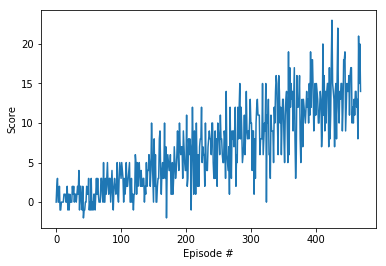

In [10]:
import matplotlib.pyplot as plt
import numpy as np

scores = dqn_unity()


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
#fig

## Let's evaluate our model

In [29]:
agent.qnetwork_local.load_state_dict(torch.load('Banana_saved_model.pth'))

In [30]:
eps = 0.
scores = []
for i in range(5):

    env_info = env.reset(train_mode=True)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = agent.select_act(state,eps)           # select an action
               
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        score += reward                                # update the score
        state = next_state                             # roll over the state to next time step
        if done:                                       # exit loop if episode finished
            break
    scores.append(score)
    #print("Score: {}".format(score))
print('Avg score:',np.mean(scores))

Avg score: 14.2


As the average score over just 5 episodes is also over 13, i.e 14.2, we can say that we have solved the environment successfully using the DQN network.